In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.manifold import TSNE
from dom_mis import generate_graph_from_similarity_matrix
from ela_feature_definition import ela_feature_names

In [13]:
def plot_dom_mis_distribution_in_clusters(cluster_df, cluster_label_column):
    print(cluster_label_column)
    cluster_only=cluster_df[cluster_label_column]
    for algorithm in ['dominant','mis']:
        all_cluster_distributions=defaultdict(lambda: pd.DataFrame())
        for similarity_threshold in [0.9,0.95,0.97]:
            for run_id in range(0,30):
                ds_results=pd.read_csv(f'results/dropna/{algorithm}/{similarity_threshold}_{run_id}.csv',index_col=[0])

                ds_results=ds_results.merge(cluster_only, left_on=['suite','fid','iid'], right_index=True)
                ds_cluster_distribution=ds_results.groupby(cluster_label_column).count()['suite'].T
                all_cluster_distributions[f'{similarity_threshold}_{run_id}']=ds_cluster_distribution

        all_cluster_distributions_df=pd.DataFrame(all_cluster_distributions).fillna(0)

        fig, ax = plt.subplots(figsize=(20,5),sharey=True)
        ax.set_title(cluster_label_column)
        sns.heatmap(all_cluster_distributions_df,cmap=sns.color_palette("Paired", 8),ax=ax)
    

In [3]:
cluster_df_10 = pd.read_csv('data/data_clustered.txt',index_col=[0],sep='\t')
cluster_df_10=cluster_df_10.set_index(["suite","fid","iid"])
cluster_label_column_10='label'

In [4]:
cluster_df_12 = pd.read_csv('data/hierarchical_clustering_12.csv',index_col=[0,1,2])
cluster_label_column_12='clustering_12_clusters'

In [5]:
cluster_df_sub_all = pd.read_csv('data/subclustering.csv',index_col=[0,1,2])
selected_cluster_counts = [10,15,21,34,46,48]

MultiIndex([(   'bbob',  1, 1),
            (   'bbob',  1, 2),
            (   'bbob',  1, 3),
            (   'bbob',  1, 4),
            (   'bbob',  1, 5),
            (   'bbob',  2, 1),
            (   'bbob',  2, 2),
            (   'bbob',  2, 3),
            (   'bbob',  2, 4),
            (   'bbob',  2, 5),
            ...
            ('cec2017', 21, 1),
            ('cec2017', 22, 1),
            ('cec2017', 23, 1),
            ('cec2017', 24, 1),
            ('cec2017', 25, 1),
            ('cec2017', 26, 1),
            ('cec2017', 27, 1),
            ('cec2017', 28, 1),
            ('cec2017', 29, 1),
            ('cec2017', 30, 1)],
           names=['suite', 'fid', 'iid'], length=221)
labels


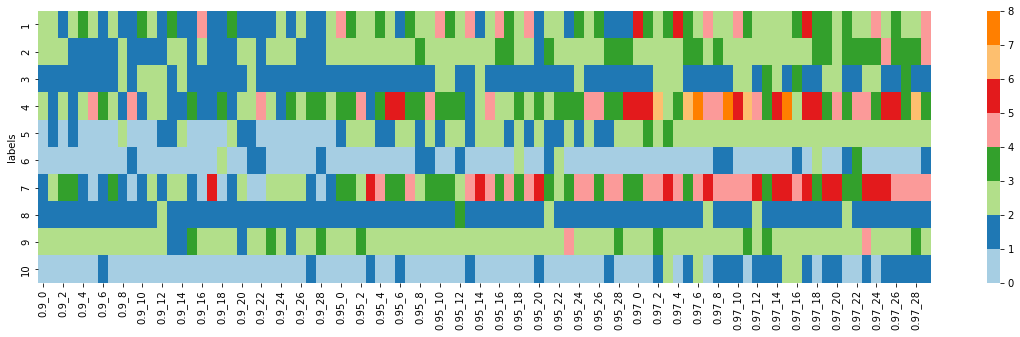

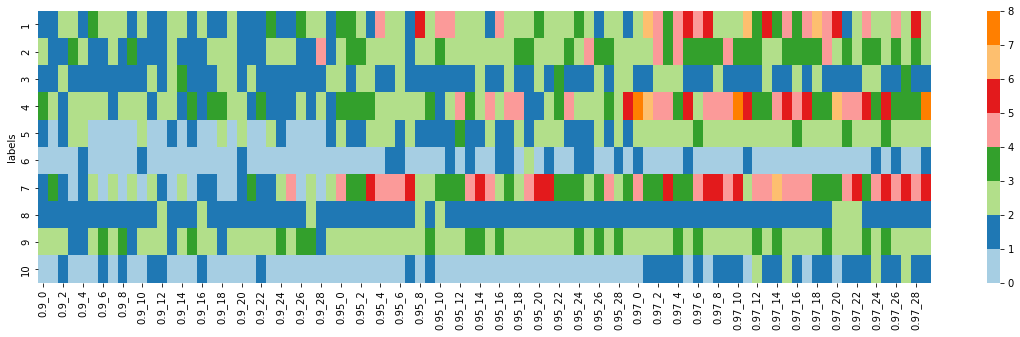

In [6]:
cluster_df_r = pd.read_csv('data/label_data.txt',index_col=[0],sep='\t')
cluster_df_r = cluster_df_r.set_index(['suite','fid','iid'],drop=True)
print(cluster_df_r.index)
cluster_label_column_r='labels'
plot_dom_mis_distribution_in_clusters(cluster_df_r, cluster_label_column_r)

In [16]:
color_labels = [i for i in range(0,100)]
col_values = sns.color_palette('Set2')
color_map = dict(zip(color_labels, col_values))

In [21]:
color_map

{0: (1.0, 0.6009538950715422, 0.0),
 1: (0.6147323794382618, 1.0, 0.0),
 2: (0.0, 1.0, 0.14758591608686492),
 3: (0.0, 1.0, 0.9276829011174367),
 4: (0.0, 0.3058397271952257, 1.0),
 5: (0.4827365728900258, 0.0, 1.0)}

In [19]:

def plot_clusters(cluster_config):
    ela = pd.read_csv('data/aggregated_ela_representation_dropna.csv', index_col=[0,1,2])
    ela_2d=TSNE(n_components=2, metric='cosine').fit_transform(ela)
    ela_2d=pd.DataFrame(ela_2d, index=ela.index, columns=['x','y'])
    for cluster_config_name, cluster_config_values in cluster_config.items():
        df = cluster_config_values['data']
        ela_2d[cluster_config_name]= df[cluster_config_values['label_column']]
        
        colors = [color_map[label] for label in df[cluster_config_values['label_column']].values]
        ela_2d.plot.scatter(x='x',y='y',c=cluster_config_name,colormap="Paired")
        

In [8]:
cluster_config={'cluster_10': {'data': cluster_df_10, 'label_column': cluster_label_column_10},
                'cluster_r': {'data': cluster_df_r, 'label_column': cluster_label_column_r},
               'cluster_12': {'data': cluster_df_12, 'label_column': cluster_label_column_12}}
selected_cluster_counts = [10,15,21,34,46,48]
for selected_cluster_count in selected_cluster_counts:
    cluster_label_column_sub=f'subclustering_{selected_cluster_count}_clusters'
    cluster_df_sub=cluster_df_sub_all[[cluster_label_column_sub]+ela_feature_names]
    cluster_config[f'cluster_sub_{selected_cluster_count}']={'data': cluster_df_sub, 'label_column': cluster_label_column_sub}

In [10]:
def analyze_single_clusters(cluster_df, cluster_label_column):
    cluster_sizes=pd.DataFrame(cluster_df[cluster_label_column].values).value_counts()
    single_clusters=[x[0] for x in cluster_sizes[cluster_sizes==1].index]
    single_cluster_indices = cluster_df[cluster_df[cluster_label_column].isin(single_clusters)].index
    
    
    
    for similarity_threshold in [0.9]:
        G = generate_graph_from_similarity_matrix(similarity_threshold)
        single_nodes = list(filter (lambda x: x[1]==0, G.degree))
        single_nodes=[x[0] for x in single_nodes]
        #sorted_nodes=sorted(G.degree, key=lambda x: x[1])[0:20]
        print(f'Single cluster indices: {len(single_cluster_indices)}')
        print(f'Similarity threshold: {similarity_threshold}')
        print(f'Single nodes: {len(single_nodes)}')
        print(f'Intersection: {len(set(single_cluster_indices).intersection(set(single_nodes)))}')
        print(f'Single clusters - single nodes : {len(set(single_cluster_indices).difference(set(single_nodes)))}')
        print(f'Single nodes - single clusters : {len(set(single_nodes).difference(set(single_cluster_indices)))}')
        print()
    

In [20]:
plot_clusters(cluster_config)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


KeyError: 8

cluster_10
label
cluster_r
labels
cluster_12
clustering_12_clusters
cluster_sub_10
subclustering_10_clusters
cluster_sub_15
subclustering_15_clusters
cluster_sub_21
subclustering_21_clusters
cluster_sub_34
subclustering_34_clusters
cluster_sub_46
subclustering_46_clusters
cluster_sub_48
subclustering_48_clusters


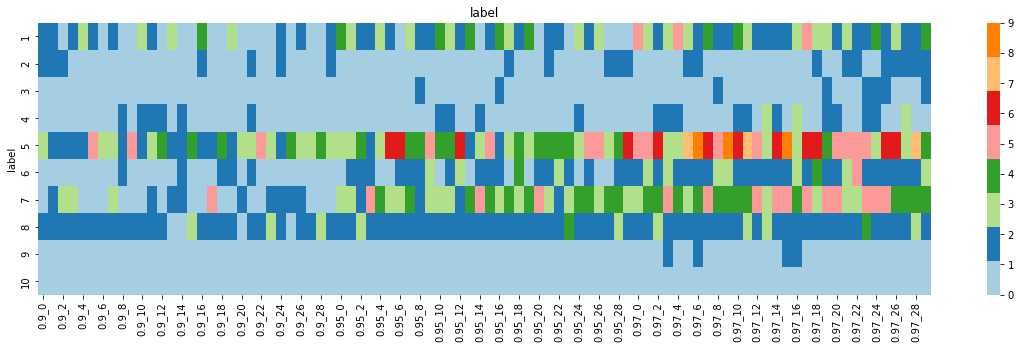

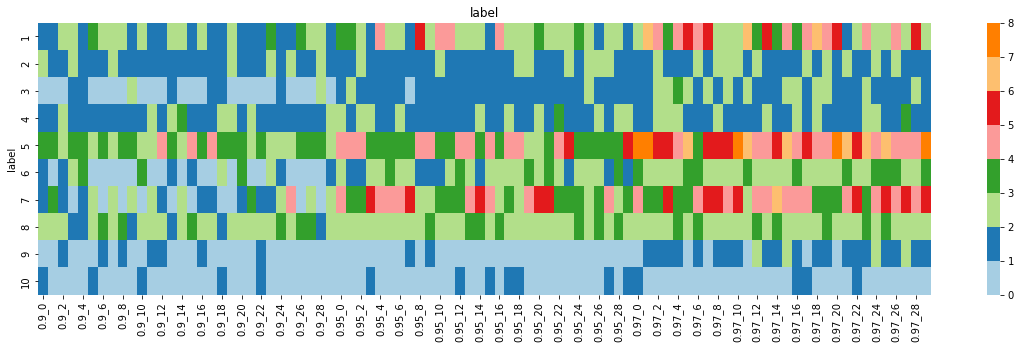

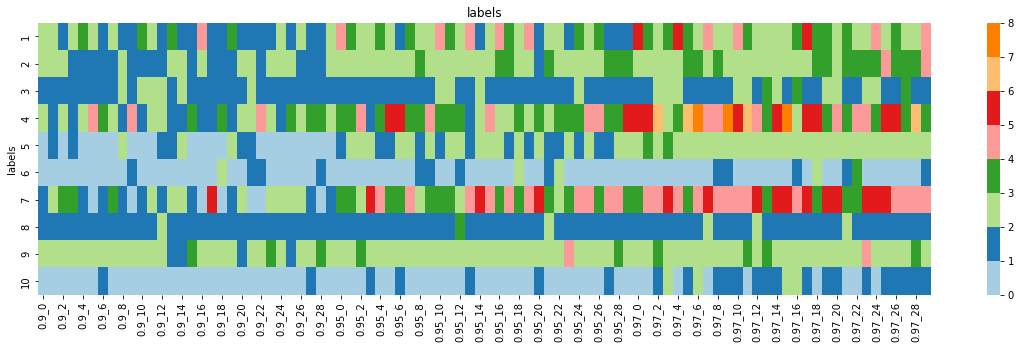

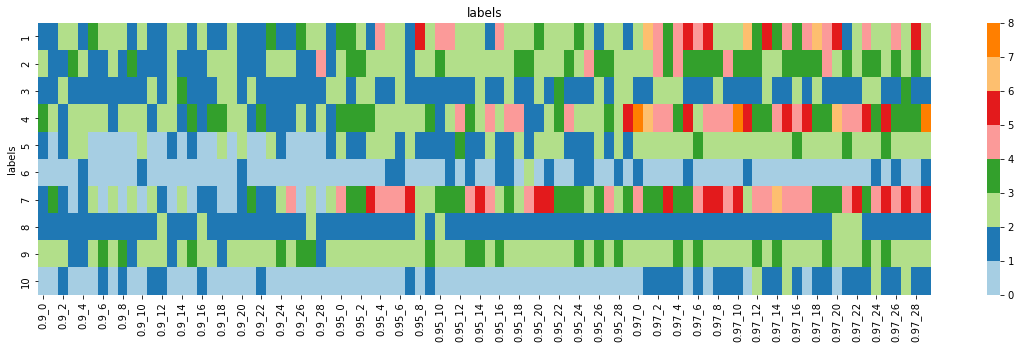

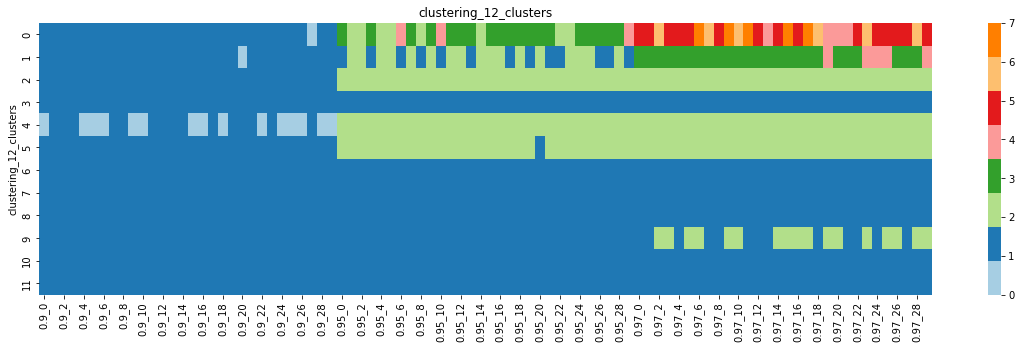

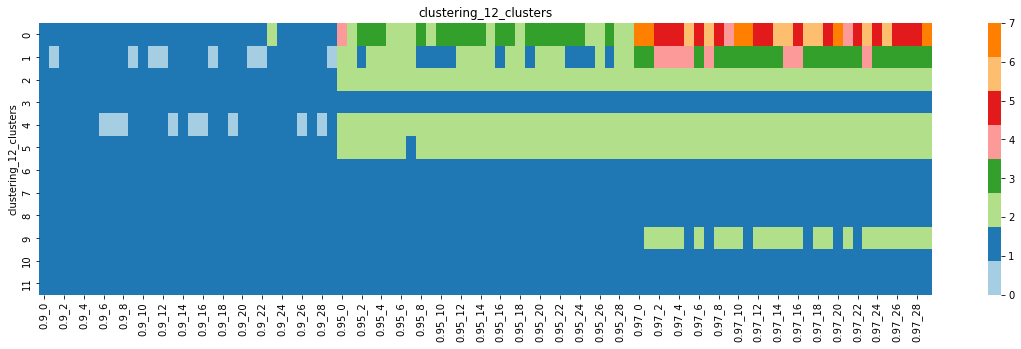

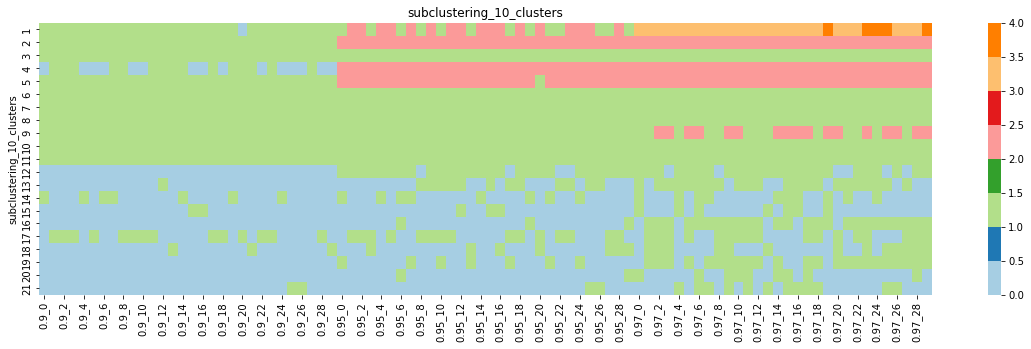

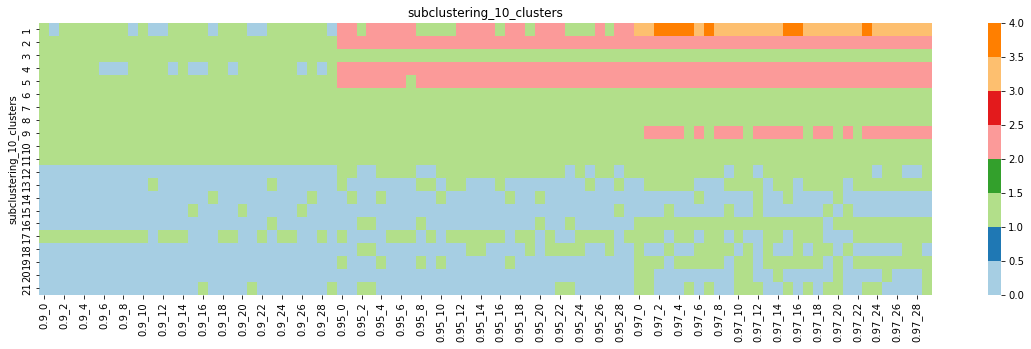

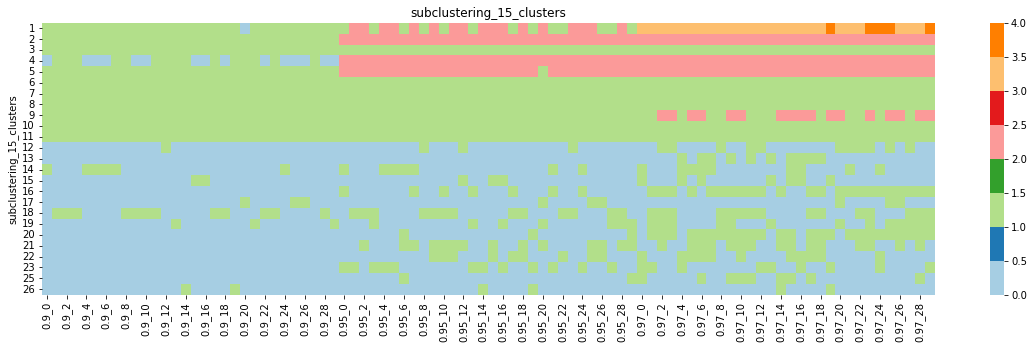

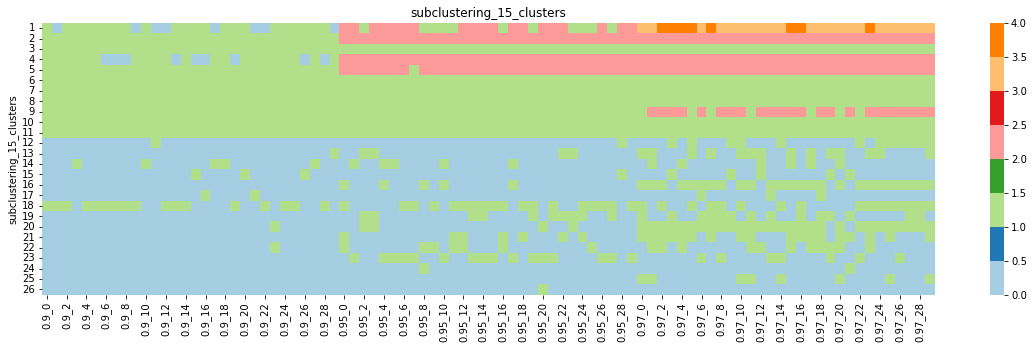

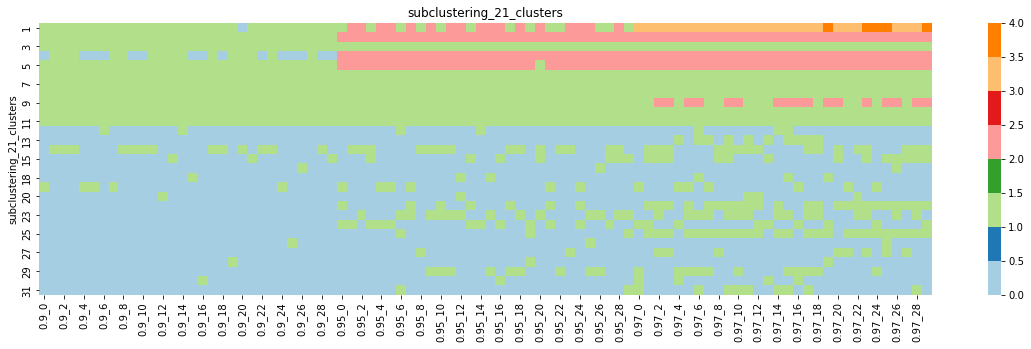

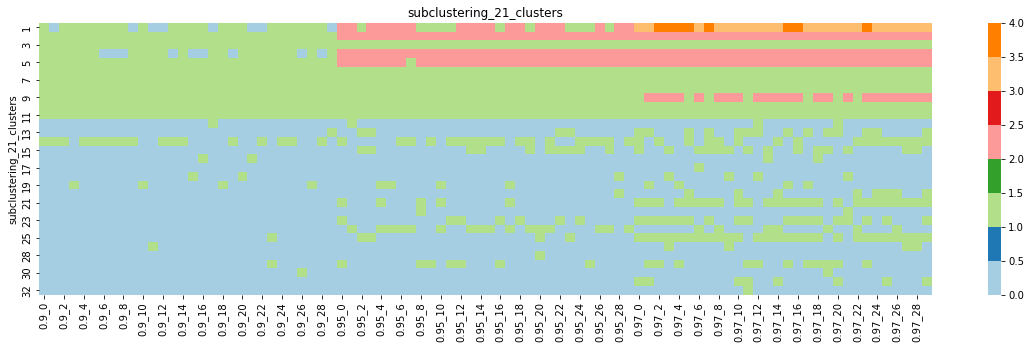

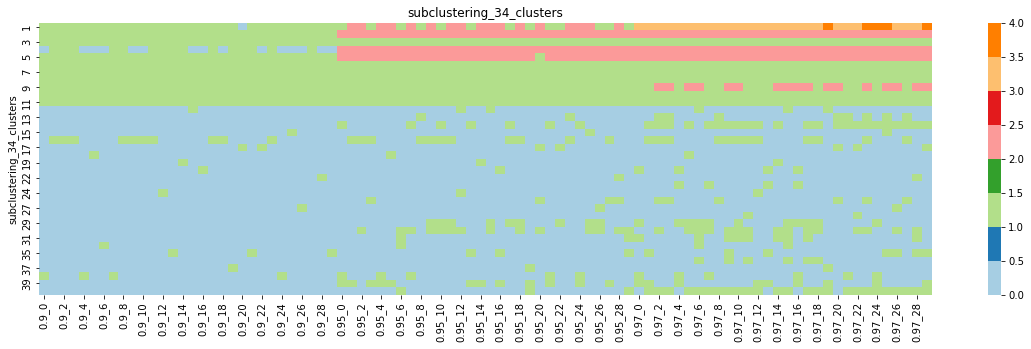

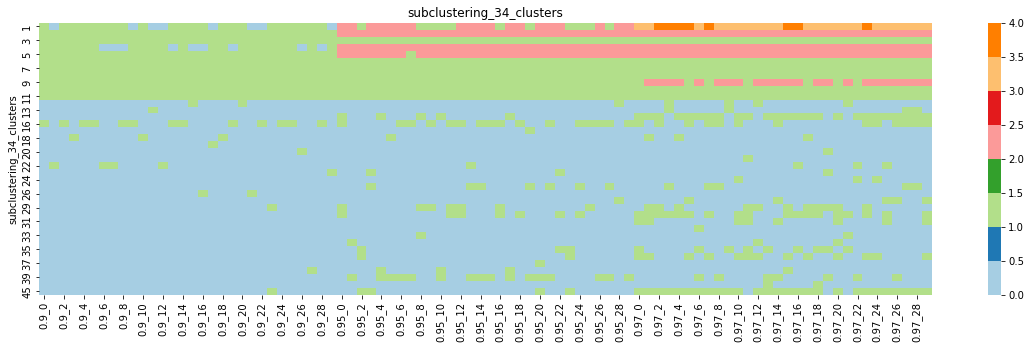

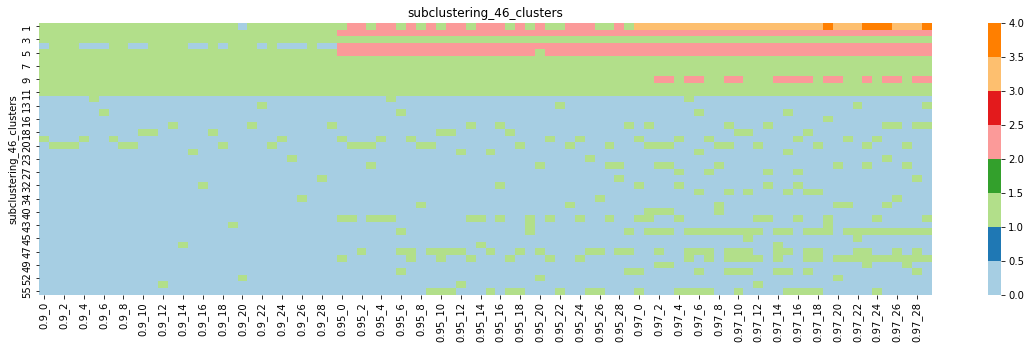

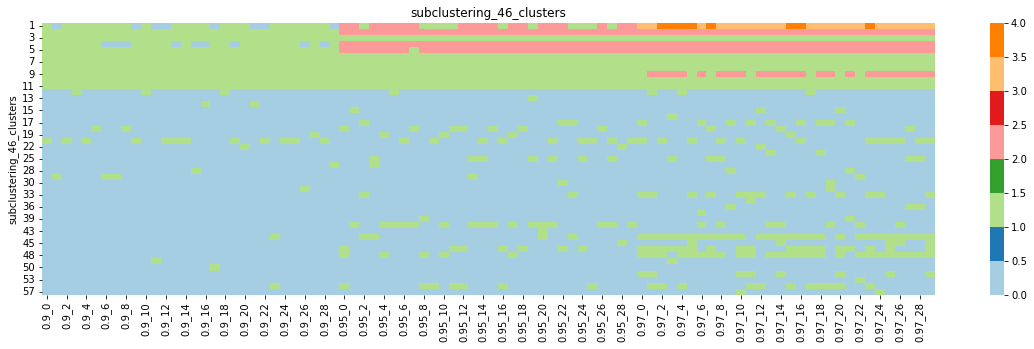

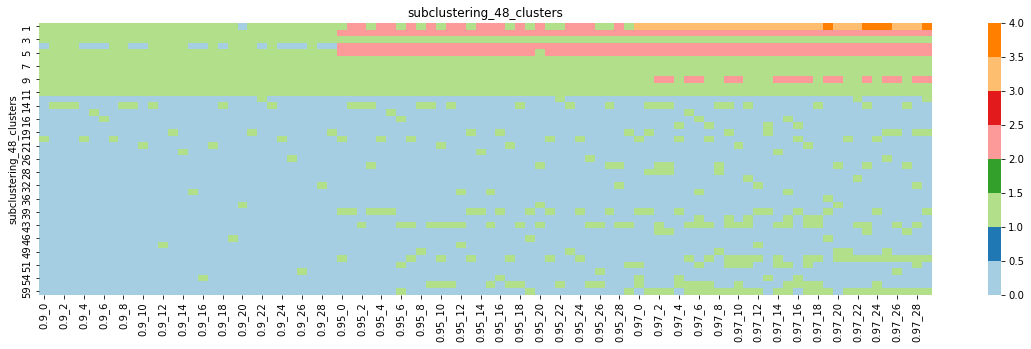

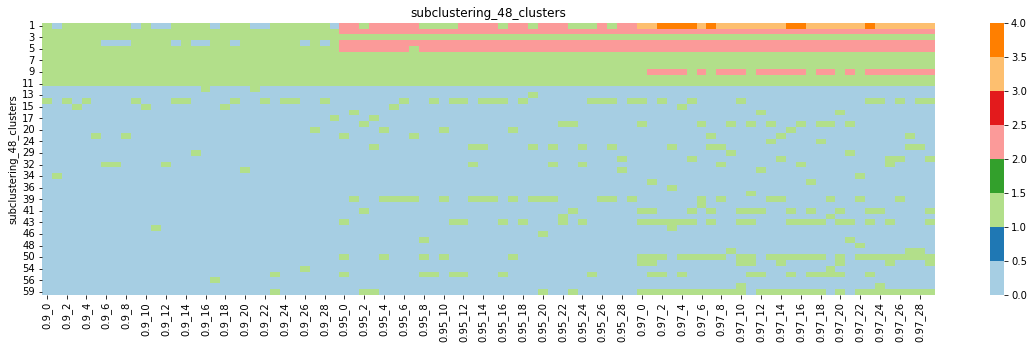

In [14]:
for cluster_config_name, cluster_config_values in cluster_config.items():
    print(cluster_config_name)
    plot_dom_mis_distribution_in_clusters(cluster_config_values['data'], cluster_config_values['label_column'])

In [12]:
for cluster_config_name, cluster_config_values in cluster_config.items():
    print(cluster_config_name)
    analyze_single_clusters(cluster_config_values['data'], cluster_config_values['label_column'])

cluster_10
Single cluster indices: 0
Similarity threshold: 0.5
Single nodes: 0
Intersection: 0
Single clusters - single nodes : 0
Single nodes - single clusters : 0

Single cluster indices: 0
Similarity threshold: 0.7
Single nodes: 0
Intersection: 0
Single clusters - single nodes : 0
Single nodes - single clusters : 0

Single cluster indices: 0
Similarity threshold: 0.9
Single nodes: 6
Intersection: 0
Single clusters - single nodes : 0
Single nodes - single clusters : 6

Single cluster indices: 0
Similarity threshold: 0.95
Single nodes: 7
Intersection: 0
Single clusters - single nodes : 0
Single nodes - single clusters : 7

Single cluster indices: 0
Similarity threshold: 0.97
Single nodes: 9
Intersection: 0
Single clusters - single nodes : 0
Single nodes - single clusters : 9

cluster_r
Single cluster indices: 0
Similarity threshold: 0.5
Single nodes: 0
Intersection: 0
Single clusters - single nodes : 0
Single nodes - single clusters : 0

Single cluster indices: 0
Similarity threshold: